# Stitching Algorithm

Import modules

In [1]:
import function_modules

import pathlib
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Input parameters

In [2]:
### Input Parameters ###
sensor = 'R15a'  # Sensor type (name of folder)
sensor_loc = 'chH'  # Channel / incident angle on plate (channel name of pickle file)
Rb = [0.5, 0.66, 2.5]  # Ball types (ball name of pickle file)

SNR = 1  # SNR threshold (float)
nbin = 5  # Number of bins for averaging (integer)
w0L = 1E4  # High-frequency cutoff (Hz)

Map channel number from PicoScope to sensor location

In [3]:
print(f'--- Working on {sensor_loc} ---')

# Map sensor locations to angles
sensor_angles = {
    'chH': 90, 'chG': 80, 'chF': 70, 'chE': 60,
    'chD': 50, 'chC': 40, 'chB': 30, 'chA': 20,
    'chX': 0,  'chY': 0
}
angle = sensor_angles.get(sensor_loc, 0)

--- Working on chH ---


Initialize arrays

In [4]:
print(f'Initializing arrays')

# Initialize arrays
Sfft_std_TS_all = np.zeros(len(Rb), dtype=complex)
Sfft_std_TL_all = np.zeros(len(Rb), dtype=complex)

Iw_TS_stitch = []
Iw_TL_stitch = []

Iw_TS_stitch_std = []
Iw_TL_stitch_std = []

Iw_TS_all_weight = []
Iw_TL_all_weight = []

Sfreq_TS_stitch = []
Sfreq_TL_stitch = []

Sfreq_TS_stitch_gap = []
Sfreq_TL_stitch_gap = []

tc_all = np.zeros(len(Rb))

Sfft_TS_valid_all = []
Iw_TS_valid_all = []
Sfreq_TS_valid_all = []
Iw_std_TS_valid_all = []

Sfft_TL_valid_all = []
Iw_TL_valid_all = []
Sfreq_TL_valid_all = []
Iw_std_TL_valid_all = []

Iw_TS_valid_SNR_all = []
Sfreq_TS_valid_SNR_all = []

Iw_TL_valid_SNR_all = []
Sfreq_TL_valid_SNR_all = []

Iw_TS_invalid_SNR_all = []
Sfreq_TS_invalid_SNR_all = []

Iw_TL_invalid_SNR_all = []
Sfreq_TL_invalid_SNR_all = []

Iw_std_TS_valid_SNR_all = []
Iw_std_TL_valid_SNR_all = []

Initializing arrays


Load `.pickle` files and save into global arrays `_all`

Reading out/R15a_0.50mm_chH.pickle
TS = 0.2 ms
TL = 20 ms
TS bin resolution 2500 Hz/bin
TL bin resolution 25 Hz/bin


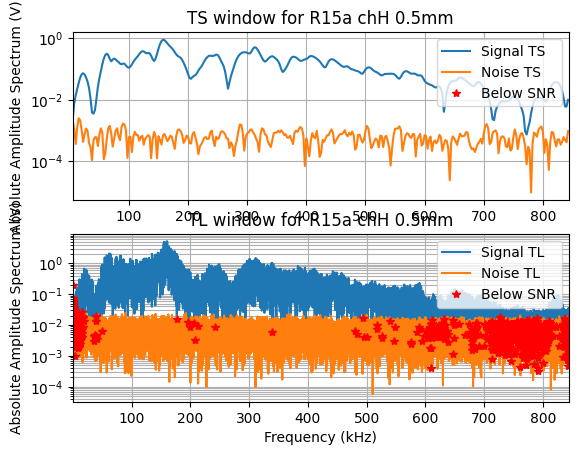

Reading out/R15a_0.66mm_chH.pickle
TS = 0.2 ms
TL = 20 ms
TS bin resolution 2500 Hz/bin
TL bin resolution 25 Hz/bin


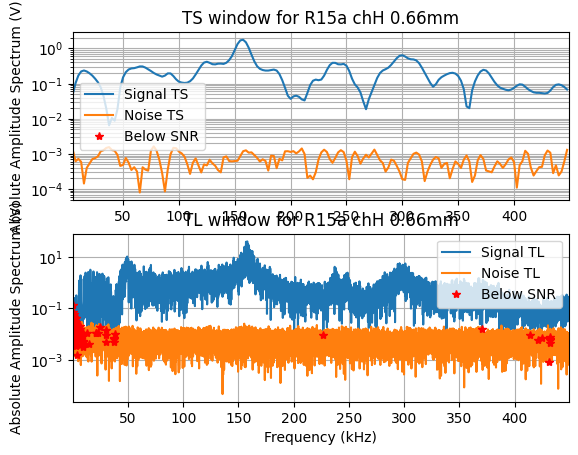

Reading out/R15a_2.50mm_chH.pickle
TS = 0.2 ms
TL = 20 ms
TS bin resolution 2500 Hz/bin
TL bin resolution 25 Hz/bin


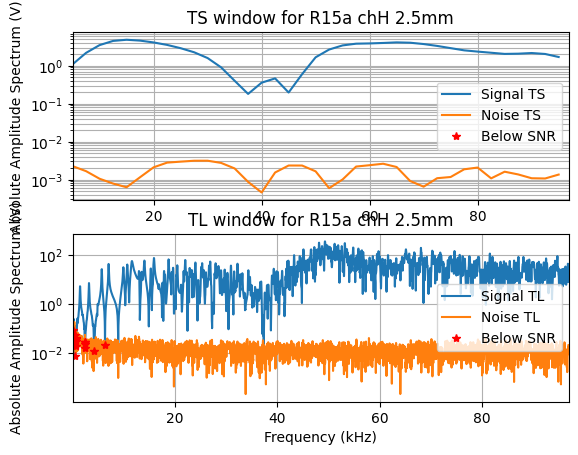

In [5]:
for Rb_idx, ball in enumerate(Rb):
    
    filename_open = f'out/{sensor}_{ball:.2f}mm_{sensor_loc}.pickle'

    if not pathlib.Path(filename_open).is_file():
        print('{:s} doesn\'t exist.'.format(filename_open))
        print('Did you run instrument_response_algorithm.py for this channel AND ball type?')
        exit()

    print(f'Reading {filename_open}')

    # Load data
    with open(filename_open, 'rb') as f:
        data = pickle.load(f)

    Iw_TS = data['Iw_TS']
    Sfreq_TS = data['Sfreq_TS']
    Iw_TL = data['Iw_TL']
    Sfreq_TL = data['Sfreq_TL']

    Iw_std_TS = data['Iw_std_TS']
    Iw_std_TL = data['Iw_std_TL']
    Sfft_std_TS = data['Sfft_std_TS']
    Sfft_std_TL = data['Sfft_std_TL']

    Sfft_TS = data['Sfft_TS']
    Nfft_TS = data['Nfft_TS']
    Nfreq_TS = data['Nfreq_TS']
    Sfft_TL = data['Sfft_TL']
    Nfft_TL = data['Nfft_TL']
    Nfreq_TL = data['Nfreq_TL']

    tc = data['tc']
    T_S = data['T_S']
    T_L = data['T_L']
    sf = data['sf']

    if Rb_idx == 0:

        Iw_TS_all = np.zeros((len(Rb), round(T_S * sf * 2)), dtype=complex)
        Iw_TL_all = np.zeros((len(Rb), round(T_L * sf * 2)), dtype=complex)
        Sfreq_TS_all = np.zeros((len(Rb), round(T_S * sf * 2)))
        Sfreq_TL_all = np.zeros((len(Rb), round(T_L * sf * 2)))
        Nfft_TS_all = np.zeros((len(Rb), round(T_S * sf * 2)), dtype=complex)
        Nfft_TL_all = np.zeros((len(Rb), round(T_L * sf * 2)), dtype=complex)
        Sfft_TS_all = np.zeros((len(Rb), round(T_S * sf * 2)), dtype=complex)
        Sfft_TL_all = np.zeros((len(Rb), round(T_L * sf * 2)), dtype=complex)
        Iw_std_TS_all = np.zeros((len(Rb), round(T_S * sf * 2)), dtype=complex)
        Iw_std_TL_all = np.zeros((len(Rb), round(T_L * sf * 2)), dtype=complex)


    Iw_TS_all[Rb_idx, :] = Iw_TS
    Iw_TL_all[Rb_idx, :] = Iw_TL

    Iw_std_TS_all[Rb_idx, :] = Iw_std_TS
    Iw_std_TL_all[Rb_idx, :] = Iw_std_TL

    Sfft_TS_all[Rb_idx, :] = Sfft_TS
    Sfft_TL_all[Rb_idx, :] = Sfft_TL

    Nfft_TS_all[Rb_idx, :] = Nfft_TS
    Nfft_TL_all[Rb_idx, :] = Nfft_TL

    Sfreq_TL_all[Rb_idx, :] = Sfreq_TL
    Sfreq_TS_all[Rb_idx, :] = Sfreq_TS

    tc_all[Rb_idx] = tc

    Sfft_std_TS_all[Rb_idx] = Sfft_std_TS
    Sfft_std_TL_all[Rb_idx] = Sfft_std_TL

    print('TS = {:g} ms'.format(T_S * 1E3))
    print('TL = {:g} ms'.format(T_L * 1E3))

    print('TS bin resolution {:g} Hz/bin'.format((sf / 2) / round(T_S * sf)))
    print('TL bin resolution {:g} Hz/bin'.format((sf / 2) / round(T_L * sf)))

    ### Crop within the valid range 1/T < w < 1/tc ###
    # Note that T is half-time length from P wave arrival so full window length is 2*T

    idx_valid_range_TS = np.where((Sfreq_TS >= (1/T_S)) & (Sfreq_TS <= (1/tc)))
    Sfft_TS_valid = Sfft_TS[idx_valid_range_TS]
    Iw_TS_valid= Iw_TS[idx_valid_range_TS]
    Sfreq_TS_valid = Sfreq_TS[idx_valid_range_TS]
    Iw_std_TS_valid = Iw_std_TS[idx_valid_range_TS]

    Sfft_TS_valid_all.append(Sfft_TS[idx_valid_range_TS])
    Iw_TS_valid_all.append(Iw_TS[idx_valid_range_TS])
    Sfreq_TS_valid_all.append(Sfreq_TS[idx_valid_range_TS])
    Iw_std_TS_valid_all.append(Iw_std_TS[idx_valid_range_TS])

    idx_valid_range_TL = np.where((Sfreq_TL >= (1 / T_L)) & (Sfreq_TL <= (1 / tc)))
    Sfft_TL_valid = Sfft_TL[idx_valid_range_TL]
    Iw_TL_valid = Iw_TL[idx_valid_range_TL]
    Sfreq_TL_valid = Sfreq_TL[idx_valid_range_TL]
    Iw_std_TL_valid = Iw_std_TL[idx_valid_range_TL]

    Sfft_TL_valid_all.append(Sfft_TL[idx_valid_range_TL])
    Iw_TL_valid_all.append(Iw_TL[idx_valid_range_TL])
    Sfreq_TL_valid_all.append(Sfreq_TL[idx_valid_range_TL])
    Iw_std_TL_valid_all.append(Iw_std_TL[idx_valid_range_TL])

    idx_valid_range_TS = np.where((Nfreq_TS >= (1 / T_S)) & (Nfreq_TS <= (1 / tc)))
    Nfft_TS_valid = Nfft_TS[idx_valid_range_TS]
    Nfreq_TS_valid = Nfreq_TS[idx_valid_range_TS]

    idx_valid_range_TL = np.where((Nfreq_TL >= (1 / T_L)) & (Nfreq_TL <= (1 / tc)))
    Nfft_TL_valid = Nfft_TL[idx_valid_range_TL]
    Nfreq_TL_valid = Nfreq_TL[idx_valid_range_TL]

    # Crop within defined SNR

    idx_valid_range_TS_SNR = np.where(abs(Sfft_TS_valid) > abs(Nfft_TS_valid) * SNR)
    idx_valid_range_TL_SNR = np.where(abs(Sfft_TL_valid) > abs(Nfft_TL_valid) * SNR)

    Iw_TS_valid_SNR = Iw_TS_valid[idx_valid_range_TS_SNR]
    Sfreq_TS_valid_SNR = Sfreq_TS_valid[idx_valid_range_TS_SNR]
    Iw_std_TS_valid_SNR = Iw_std_TS_valid[idx_valid_range_TS_SNR]

    Iw_TS_valid_SNR_all.append(Iw_TS_valid[idx_valid_range_TS_SNR])
    Sfreq_TS_valid_SNR_all.append(Sfreq_TS_valid[idx_valid_range_TS_SNR])
    Iw_std_TS_valid_SNR_all.append(Iw_std_TS_valid[idx_valid_range_TS_SNR])

    Iw_TL_valid_SNR = Iw_TL_valid[idx_valid_range_TL_SNR]
    Sfreq_TL_valid_SNR = Sfreq_TL_valid[idx_valid_range_TL_SNR]
    Iw_std_TL_valid_SNR = Iw_std_TL_valid[idx_valid_range_TL_SNR]

    Iw_TL_valid_SNR_all.append(Iw_TL_valid[idx_valid_range_TL_SNR])
    Sfreq_TL_valid_SNR_all.append(Sfreq_TL_valid[idx_valid_range_TL_SNR])
    Iw_std_TL_valid_SNR_all.append(Iw_std_TL_valid[idx_valid_range_TL_SNR])

    idx_invalid_range_TS_SNR = np.where(abs(Sfft_TS_valid) < abs(Nfft_TS_valid) * SNR)
    idx_invalid_range_TL_SNR = np.where(abs(Sfft_TL_valid) < abs(Nfft_TL_valid) * SNR)

    Iw_TS_invalid_SNR = Iw_TS_valid[idx_invalid_range_TS_SNR]
    Sfreq_TS_invalid_SNR = Sfreq_TS_valid[idx_invalid_range_TS_SNR]
    Sfft_TS_invalid_SNR = Sfft_TS_valid[idx_invalid_range_TS_SNR]
    Nfft_TS_invalid_SNR = Nfft_TS_valid[idx_invalid_range_TS_SNR]

    Iw_TS_invalid_SNR_all.append(Iw_TS_valid[idx_invalid_range_TS_SNR])
    Sfreq_TS_invalid_SNR_all.append(Sfreq_TS_valid[idx_invalid_range_TS_SNR])

    Iw_TL_invalid_SNR = Iw_TL_valid[idx_invalid_range_TL_SNR]
    Sfreq_TL_invalid_SNR = Sfreq_TL_valid[idx_invalid_range_TL_SNR]
    Sfft_TL_invalid_SNR = Sfft_TL_valid[idx_invalid_range_TL_SNR]
    Nfft_TL_invalid_SNR = Nfft_TL_valid[idx_invalid_range_TL_SNR]

    Iw_TL_invalid_SNR_all.append(Iw_TL_valid[idx_invalid_range_TL_SNR])
    Sfreq_TL_invalid_SNR_all.append(Sfreq_TL_valid[idx_invalid_range_TL_SNR])

    ### Lab data, noise and instrument response for TS and TL ###
    plt.figure(1)

    plt.subplot(211)
    plt.plot(Sfreq_TS_valid / 1E3, abs(Sfft_TS_valid), label='Signal TS')
    plt.plot(Sfreq_TS_valid / 1E3, abs(Nfft_TS_valid), label='Noise TS')
    plt.plot(Sfreq_TS_invalid_SNR / 1E3, abs(Sfft_TS_invalid_SNR), 'r*', label='Below SNR')
    plt.title('TS window for {:s} {:s} {:2g}mm'.format(sensor, sensor_loc, ball))
    plt.legend()
    plt.ylabel('Absolute Amplitude Spectrum (V)')
    plt.yscale('log')
    plt.xlim(((1 / (T_S)) / 1E3, (1 / tc) / 1E3))
    plt.grid(True, which='both')

    plt.subplot(212)
    plt.plot(Sfreq_TL_valid / 1E3, abs(Sfft_TL_valid), label='Signal TL')
    plt.plot(Sfreq_TL_valid / 1E3, abs(Nfft_TL_valid), label='Noise TL')
    plt.plot(Sfreq_TL_invalid_SNR / 1E3, abs(Sfft_TL_invalid_SNR), 'r*', label='Below SNR')
    plt.title('TL window for {:s} {:s} {:2g}mm'.format(sensor, sensor_loc, ball))
    plt.legend()
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('Absolute Amplitude Spectrum (V)')
    # plt.xscale('log')
    plt.yscale('log')
    plt.xlim(((1 / (T_L)) / 1E3, (1 / tc) / 1E3))
    plt.grid(True, which='both')

    plt.show()

Now that all data for each ball has been collected into global arrays (`_all`) we can process them at once

Crop short window $T^S$

In [6]:
# Cropping TS for valid range
print('Cropping TS window')
for j in range(round(T_S*sf*2)):
    tmp_Iw = []
    tmp_Iw_std = []
    tmp_weight = []
    tmp_count = 0
    for i in range(len(Rb)):
        if (Sfreq_TS_all[i,j] >= 1/T_S) and (Sfreq_TS_all[i,j] <= 1/tc_all[i]):
            if abs(Sfft_TS_all[i,j]) > abs(Nfft_TS_all[i,j]) * SNR:
                tmp_Iw.append(Iw_TS_all[i,j])
                tmp_Iw_std.append(Iw_std_TS_all[i,j])
                tmp_weight.append(abs(Sfft_TS_all[i,j])/abs(Nfft_TS_all[i,j]))
            else:
                tmp_count = tmp_count + 1
        elif (Sfreq_TS_all[i,j] >= 1/T_S) and (Sfreq_TS_all[i,j] <= 1/np.min(tc_all)):
            tmp_count = tmp_count + 1

    if tmp_count == len(Rb):
        Sfreq_TS_stitch_gap.append(Sfreq_TS_all[i, j])

    if tmp_Iw:
        Iw_TS_stitch.append(tmp_Iw)
        Iw_TS_stitch_std.append(tmp_Iw_std)
        Iw_TS_all_weight.append(tmp_weight)
        Sfreq_TS_stitch.append(Sfreq_TS[j])

Cropping TS window


Weighted average stitch all instrument responses for short window

In [7]:
Iw_TS_stitch_wavg = np.zeros(len(Iw_TS_stitch), dtype=complex)
Iw_TS_stitch_std_wavg = np.zeros(len(Iw_TS_stitch_std))

# Weighted average TS
print('Stitching TS window')
for j in range(len(Iw_TS_stitch)):
    Iw_TS_stitch_wavg[j] = np.average(np.abs(Iw_TS_stitch[j]), weights=Iw_TS_all_weight[j])
    for k in range(len(Iw_TS_stitch_std[j])):
        Iw_TS_stitch_std_wavg[j] = (Iw_TS_stitch_std_wavg[j] +
                                    (Iw_TS_all_weight[j][k]*np.abs(Iw_TS_stitch_std[j][k])/np.sum(Iw_TS_all_weight[j]))**2)
    Iw_TS_stitch_std_wavg[j] = np.sqrt(Iw_TS_stitch_std_wavg[j])

Stitching TS window


Crop long window $T^L$

In [8]:
# Cropping TL for valid range
print('Cropping TL window')
for j in range(round(T_L*sf*2)):
    tmp_Iw = []
    tmp_Iw_std = []
    tmp_weight = []
    tmp_count = 0
    for i in range(len(Rb)):
        if (Sfreq_TL_all[i,j] >= 1/T_L) and (Sfreq_TL_all[i,j] <= 1/tc_all[i]):
            if abs(Sfft_TL_all[i,j]) > abs(Nfft_TL_all[i,j]) * SNR:
                tmp_Iw.append(Iw_TL_all[i,j])
                tmp_Iw_std.append(Iw_std_TL_all[i,j])
                tmp_weight.append(abs(Sfft_TL_all[i,j])/abs(Nfft_TL_all[i,j]))
            else:
                tmp_count = tmp_count + 1
        elif (Sfreq_TL_all[i,j] >= 1/T_L) and (Sfreq_TL_all[i,j] <= 1/np.min(tc_all)):
            tmp_count = tmp_count + 1

    if tmp_count == len(Rb):
        Sfreq_TL_stitch_gap.append(Sfreq_TL_all[i, j])

    if tmp_Iw:
        Iw_TL_stitch.append(tmp_Iw)
        Iw_TL_stitch_std.append(tmp_Iw_std)
        Iw_TL_all_weight.append(tmp_weight)
        Sfreq_TL_stitch.append(Sfreq_TL[j])

Cropping TL window


Weighted average stitch all instrument responses for long window

In [9]:
Iw_TL_stitch_wavg = np.zeros(len(Iw_TL_stitch), dtype=complex)
Iw_TL_stitch_std_wavg = np.zeros(len(Iw_TL_stitch_std))

# Weighted average TL
print('Stitching TL window')
for j in range(len(Iw_TL_stitch)):
    Iw_TL_stitch_wavg[j] = np.average(np.abs(Iw_TL_stitch[j]), weights=Iw_TL_all_weight[j])
    for k in range(len(Iw_TL_stitch_std[j])):
        Iw_TL_stitch_std_wavg[j] = (Iw_TL_stitch_std_wavg[j] +
                                    (Iw_TL_all_weight[j][k]*np.abs(Iw_TL_stitch_std[j][k])/np.sum(Iw_TL_all_weight[j]))**2)
    Iw_TL_stitch_std_wavg[j] = np.sqrt(Iw_TL_stitch_std_wavg[j])

Stitching TL window


Check if any data gap exist within short window, otherwise set a lower `SNR` threhold

In [10]:
if len(Sfreq_TS_stitch_gap) > 0:
    print('*** Data gap in stitched TS instrument response ***')
    print('Set a lower SNR threshold')

Bin statistics for long window `nbin` \
If data gap exist within long window `bin_fft` function will printout a message \
print('*** Data gap in re-binned data ***') \
print('Set a lower SNR threshold OR set a greater nbin.')

In [11]:
# Binning instrument response of TL to improve accuracy
bin_width = (np.min(np.diff(Sfreq_TL_stitch))) * nbin
print('TL re-binned resolution {:g} Hz/bin'.format(bin_width))
if nbin != 0:
    [bin_means, bin_centers, bin_std_means, nan_idx] = function_modules.bin_fft(Sfreq_TL_stitch, abs(Iw_TL_stitch_wavg), bin_width, Iw_TL_stitch_std_wavg, bin_min=1/T_L)
else:
    bin_means = abs(Iw_TL_stitch_wavg)
    bin_centers = np.array(abs(Sfreq_TL_stitch))
    bin_std_means = abs(Iw_TL_stitch_std_wavg)
    nan_idx = []

TL re-binned resolution 125 Hz/bin
*** Data gap in re-binned data ***
Set a lower SNR threshold OR set a greater nbin.


/home/geogroup3/irazu_output/EK/Calibration/PyCalibrAE/function_modules.py:544: RuntimeWarning: invalid value encountered in divide
  bin_std_means = np.sqrt(bin_std_means)/bin_std_count


Crop binned statistics below `w0L`

In [12]:
bin_centers_lp_idx = np.asarray(bin_centers <= w0L).nonzero()[0]
bin_means_lp = bin_means[bin_centers_lp_idx]
bin_centers_lp = bin_centers[bin_centers_lp_idx]
bin_std_means_lp = bin_std_means[bin_centers_lp_idx]

bin_centers_lp_idx_gap = np.asarray(bin_centers[nan_idx] <= w0L).nonzero()[0]
bin_means_lp_gap = bin_means[bin_centers_lp_idx_gap]

Save `.pickle` file containing stitched short and long window instrument response and error

In [13]:
instrument_response = ({
    # Bin statistics TL
    'Iw_TL_binned': bin_means_lp,
    'Sfreq_TL_stitch_binned': bin_centers_lp,
    'Iw_TL_stitch_std_wavg_binned': bin_std_means_lp,

    # Cropped and stitched TL
    'Sfreq_TL_stitch': Sfreq_TL_stitch,
    'Iw_TL_stitch_wavg': Iw_TL_stitch_wavg,
    'Iw_TL_stitch_std_wavg': Iw_TL_stitch_std_wavg,

    # Cropped and stitched TS
    'Sfreq_TS_stitch': Sfreq_TS_stitch,
    'Iw_TS_stitch_wavg': Iw_TS_stitch_wavg,
    'Iw_TS_stitch_std_wavg': Iw_TS_stitch_std_wavg,
})

filename_pickle = 'out/{:s}_{:s}.pickle'.format(sensor, sensor_loc)
print('Saving {:s}'.format(filename_pickle))
with open(filename_pickle, 'wb') as fp:
    pickle.dump(instrument_response, fp, pickle.HIGHEST_PROTOCOL)

Saving out/R15a_chH.pickle


Visually plot the stitching algorithm for the short window \
Data gaps in the weighted average instrument response are shown as brown stars (if present)

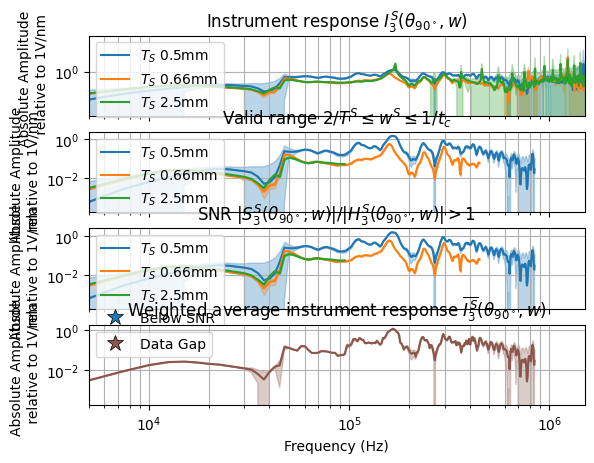

In [14]:
plt.figure(2)
plt.subplot(411)
if len(Rb) >= 1:
    plt.plot(Sfreq_TS[0:int(len(Sfreq_TS) / 2)], (abs(Iw_TS_all[0, 0:int(len(Iw_TS)/2)]/1E9)),
             label='$T_S$ {:2g}mm'.format(Rb[0]))
    plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                     (abs(Iw_TS_all[0, 0:int(len(Sfreq_TS) / 2)]/1E9) + abs(Iw_std_TS_all[0, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     (abs(Iw_TS_all[0, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
    plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                     (abs(Iw_TS_all[0, 0:int(len(Sfreq_TS) / 2)]/1E9) - abs(Iw_std_TS_all[0, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     (abs(Iw_TS_all[0, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
if len(Rb) >= 2:
    plt.plot(Sfreq_TS[0:int(len(Sfreq_TS) / 2)], (abs(Iw_TS_all[1, 0:int(len(Iw_TS) / 2)]/1E9)),
             label='$T_S$ {:2g}mm'.format(Rb[1]))
    plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                     (abs(Iw_TS_all[1, 0:int(len(Sfreq_TS) / 2)]/1E9) + abs(Iw_std_TS_all[1, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     (abs(Iw_TS_all[1, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
    plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                     (abs(Iw_TS_all[1, 0:int(len(Sfreq_TS) / 2)]/1E9) - abs(Iw_std_TS_all[1, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     (abs(Iw_TS_all[1, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
if len(Rb) >= 3:
    plt.plot(Sfreq_TS[0:int(len(Sfreq_TS) / 2)], (abs(Iw_TS_all[2, 0:int(len(Iw_TS) / 2)]/1E9)),
             label='$T_S$ {:2g}mm'.format(Rb[2]))
    plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                     (abs(Iw_TS_all[2, 0:int(len(Sfreq_TS) / 2)]/1E9) + abs(Iw_std_TS_all[2, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     (abs(Iw_TS_all[2, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     color='tab:green',
                     alpha=0.3)
    plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                     (abs(Iw_TS_all[2, 0:int(len(Sfreq_TS) / 2)]/1E9) - abs(Iw_std_TS_all[2, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     (abs(Iw_TS_all[2, 0:int(len(Sfreq_TS) / 2)]/1E9)),
                     color='tab:green',
                     alpha=0.3)
plt.title('Instrument response $I_3^S(\\theta_{{{:g}^\circ}},w)$'.format(angle))
plt.legend()
plt.ylabel('Absolute Amplitude \n relative to 1V/nm')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.tick_params(labelbottom=False)
plt.xlim(1 / T_S, 1.5E6)

plt.subplot(412)
if len(Rb) >= 1:
    plt.plot(Sfreq_TS_valid_all[0], (abs(Iw_TS_valid_all[0]/1E9)), label='$T_S$ {:2g}mm'.format(Rb[0]))
    plt.fill_between(Sfreq_TS_valid_all[0],
                     (abs(Iw_TS_valid_all[0]/1E9) + abs(Iw_std_TS_valid_all[0]/1E9)),
                     (abs(Iw_TS_valid_all[0]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
    plt.fill_between(Sfreq_TS_valid_all[0],
                     (abs(Iw_TS_valid_all[0]/1E9) - abs(Iw_std_TS_valid_all[0]/1E9)),
                     (abs(Iw_TS_valid_all[0]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
if len(Rb) >= 2:
    plt.plot(Sfreq_TS_valid_all[1], (abs(Iw_TS_valid_all[1]/1E9)), label='$T_S$ {:2g}mm'.format(Rb[1]))
    plt.fill_between(Sfreq_TS_valid_all[1],
                     (abs(Iw_TS_valid_all[1]/1E9) + abs(Iw_std_TS_valid_all[1]/1E9)),
                     (abs(Iw_TS_valid_all[1]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
    plt.fill_between(Sfreq_TS_valid_all[1],
                     (abs(Iw_TS_valid_all[1]/1E9) - abs(Iw_std_TS_valid_all[1]/1E9)),
                     (abs(Iw_TS_valid_all[1]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
if len(Rb) >= 3:
    plt.plot(Sfreq_TS_valid_all[2], (abs(Iw_TS_valid_all[2]/1E9)), label='$T_S$ {:2g}mm'.format(Rb[2]))
    plt.fill_between(Sfreq_TS_valid_all[2],
                     (abs(Iw_TS_valid_all[2]/1E9) + abs(Iw_std_TS_valid_all[2]/1E9)),
                     (abs(Iw_TS_valid_all[2]/1E9)),
                     color='tab:green',
                     alpha=0.3)
    plt.fill_between(Sfreq_TS_valid_all[2],
                     (abs(Iw_TS_valid_all[2]/1E9) - abs(Iw_std_TS_valid_all[2]/1E9)),
                     (abs(Iw_TS_valid_all[2]/1E9)),
                     color='tab:green',
                     alpha=0.3)
plt.title('Valid range $2/T^S \leq w^S \leq 1/t_c$')
plt.legend()
# plt.ylabel('Amplitude relative to Vs/m')
plt.ylabel('Absolute Amplitude \n relative to 1V/nm')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.tick_params(labelbottom=False)
plt.xlim(1 / T_S, 1.5E6)

plt.subplot(413)
if len(Rb) >= 1:
    plt.plot(Sfreq_TS_valid_SNR_all[0], (abs(Iw_TS_valid_SNR_all[0]/1E9)),
             label='$T_S$ {:2g}mm'.format(Rb[0]))
    plt.fill_between(Sfreq_TS_valid_SNR_all[0],
                     (abs(Iw_TS_valid_SNR_all[0]/1E9) + abs(Iw_std_TS_valid_SNR_all[0]/1E9)),
                     (abs(Iw_TS_valid_SNR_all[0]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
    plt.fill_between(Sfreq_TS_valid_SNR_all[0],
                     (abs(Iw_TS_valid_SNR_all[0]/1E9) - abs(Iw_std_TS_valid_SNR_all[0]/1E9)),
                     (abs(Iw_TS_valid_SNR_all[0]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
if len(Rb) >= 2:
    plt.plot(Sfreq_TS_valid_SNR_all[1], (abs(Iw_TS_valid_SNR_all[1]/1E9)),
             label='$T_S$ {:2g}mm'.format(Rb[1]))
    plt.fill_between(Sfreq_TS_valid_SNR_all[1],
                     (abs(Iw_TS_valid_SNR_all[1]/1E9) + abs(Iw_std_TS_valid_SNR_all[1]/1E9)),
                     (abs(Iw_TS_valid_SNR_all[1]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
    plt.fill_between(Sfreq_TS_valid_SNR_all[1],
                     (abs(Iw_TS_valid_SNR_all[1]/1E9) - abs(Iw_std_TS_valid_SNR_all[1]/1E9)),
                     (abs(Iw_TS_valid_SNR_all[1]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
if len(Rb) >= 3:
    plt.plot(Sfreq_TS_valid_SNR_all[2], (abs(Iw_TS_valid_SNR_all[2]/1E9)),
             label='$T_S$ {:2g}mm'.format(Rb[2]))
    plt.fill_between(Sfreq_TS_valid_SNR_all[2],
                     (abs(Iw_TS_valid_SNR_all[2]/1E9) + abs(Iw_std_TS_valid_SNR_all[2]/1E9)),
                     (abs(Iw_TS_valid_SNR_all[2]/1E9)),
                     color='tab:green',
                     alpha=0.3)
    plt.fill_between(Sfreq_TS_valid_SNR_all[2],
                     (abs(Iw_TS_valid_SNR_all[2]/1E9) - abs(Iw_std_TS_valid_SNR_all[2]/1E9)),
                     (abs(Iw_TS_valid_SNR_all[2]/1E9)),
                     color='tab:green',
                     alpha=0.3)
if len(Rb) >= 1:
    plt.plot(Sfreq_TS_invalid_SNR_all[0], (abs(Iw_TS_invalid_SNR_all[0]/1E9)), '*', color='tab:blue', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Below SNR')
if len(Rb) >= 2:
    plt.plot(Sfreq_TS_invalid_SNR_all[1], (abs(Iw_TS_invalid_SNR_all[1]/1E9)), '*', color='tab:orange', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Below SNR')
if len(Rb) >= 3:
    plt.plot(Sfreq_TS_invalid_SNR_all[2], (abs(Iw_TS_invalid_SNR_all[2]/1E9)), '*', color='tab:green', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Below SNR')

plt.title('SNR $ |S_3^S(\\theta_{{{:g}^\circ}},w)|/|H_3^S(\\theta_{{{:g}^\circ}},w)| > {:d}$'.format(angle,angle,SNR))
plt.legend()
plt.ylabel('Absolute Amplitude \n relative to 1V/nm')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.tick_params(labelbottom=False)
plt.xlim(1 / T_S, 1.5E6)

plt.subplot(414)
plt.plot(Sfreq_TS_stitch, (abs(Iw_TS_stitch_wavg/1E9)),
          color='tab:brown')
plt.fill_between(Sfreq_TS_stitch,
                 (abs(Iw_TS_stitch_wavg/1E9) + abs(Iw_TS_stitch_std_wavg/1E9)),
                 (abs(Iw_TS_stitch_wavg/1E9)),
                 color='tab:brown',
                 alpha=0.3)
plt.fill_between(Sfreq_TS_stitch,
                 (abs(Iw_TS_stitch_wavg/1E9) - abs(Iw_TS_stitch_std_wavg/1E9)),
                 (abs(Iw_TS_stitch_wavg/1E9)),
                 color='tab:brown',
                 alpha=0.3)
plt.plot(Sfreq_TS_stitch_gap, (np.min(abs(Iw_TS_stitch_wavg/1E9))*np.ones((1,len(Sfreq_TS_stitch_gap))).flatten()),'*',
          color='tab:brown', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Data Gap')
plt.title('Weighted average instrument response $\overline{{I_3^S}}(\\theta_{{{:g}^\circ}},w)$'.format(angle))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Absolute Amplitude \n relative to 1V/nm')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both')
plt.xlim(1 / T_S, 1.5E6)
plt.show()

Visually plot the stitching algorithm for the long window \
Data gaps in the weighted average instrument response are shown as brown stars (if present) \
Data gaps in the binned `nbin` instrument response are shown as olive stars (if present)

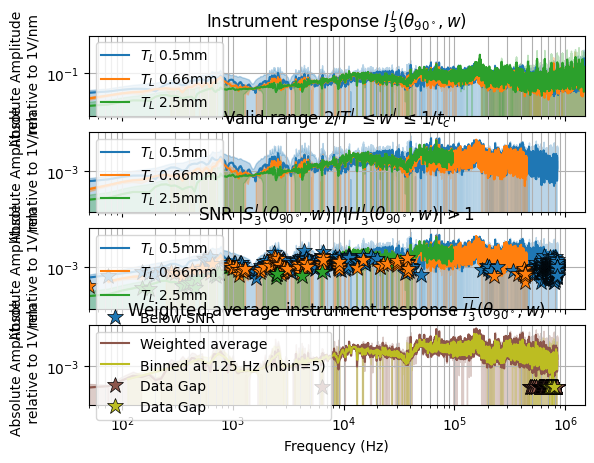

In [15]:
plt.figure(3)
plt.subplot(411)
if len(Rb) >= 1:
    plt.plot(Sfreq_TL[0:int(len(Sfreq_TL) / 2)], (abs(Iw_TL_all[0, 0:int(len(Iw_TL)/2)]/1E9)),
             label='$T_L$ {:2g}mm'.format(Rb[0]))
    plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                     (abs(Iw_TL_all[0, 0:int(len(Sfreq_TL) / 2)]/1E9) + abs(Iw_std_TL_all[0, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     (abs(Iw_TL_all[0, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
    plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                     (abs(Iw_TL_all[0, 0:int(len(Sfreq_TL) / 2)]/1E9) - abs(Iw_std_TL_all[0, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     (abs(Iw_TL_all[0, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
if len(Rb) >= 2:
    plt.plot(Sfreq_TL[0:int(len(Sfreq_TL) / 2)], (abs(Iw_TL_all[1, 0:int(len(Iw_TL) / 2)]/1E9)),
             label='$T_L$ {:2g}mm'.format(Rb[1]))
    plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                     (abs(Iw_TL_all[1, 0:int(len(Sfreq_TL) / 2)]/1E9) + abs(Iw_std_TL_all[1, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     (abs(Iw_TL_all[1, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
    plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                     (abs(Iw_TL_all[1, 0:int(len(Sfreq_TL) / 2)]/1E9) - abs(Iw_std_TL_all[1, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     (abs(Iw_TL_all[1, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
if len(Rb) >= 3:
    plt.plot(Sfreq_TL[0:int(len(Sfreq_TL) / 2)], (abs(Iw_TL_all[2, 0:int(len(Iw_TL) / 2)]/1E9)),
             label='$T_L$ {:2g}mm'.format(Rb[2]))
    plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                     (abs(Iw_TL_all[2, 0:int(len(Sfreq_TL) / 2)]/1E9) + abs(Iw_std_TL_all[2, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     (abs(Iw_TL_all[2, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     color='tab:green',
                     alpha=0.3)
    plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                     (abs(Iw_TL_all[2, 0:int(len(Sfreq_TL) / 2)]/1E9) - abs(Iw_std_TL_all[2, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     (abs(Iw_TL_all[2, 0:int(len(Sfreq_TL) / 2)]/1E9)),
                     color='tab:green',
                     alpha=0.3)
plt.title('Instrument response $I_3^L(\\theta_{{{:g}^\circ}},w)$'.format(angle))
plt.legend()
# plt.ylabel('Amplitude relative to Vs/m')
plt.ylabel('Absolute Amplitude \n relative to 1V/nm')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.tick_params(labelbottom=False)
plt.xlim(1 / T_L, 1.5E6)

plt.subplot(412)
if len(Rb) >= 1:
    plt.plot(Sfreq_TL_valid_all[0], (abs(Iw_TL_valid_all[0]/1E9)), label='$T_L$ {:2g}mm'.format(Rb[0]))
    plt.fill_between(Sfreq_TL_valid_all[0],
                     (abs(Iw_TL_valid_all[0]/1E9) + abs(Iw_std_TL_valid_all[0]/1E9)),
                     (abs(Iw_TL_valid_all[0]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
    plt.fill_between(Sfreq_TL_valid_all[0],
                     (abs(Iw_TL_valid_all[0]/1E9) - abs(Iw_std_TL_valid_all[0]/1E9)),
                     (abs(Iw_TL_valid_all[0]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
if len(Rb) >= 2:
    plt.plot(Sfreq_TL_valid_all[1], (abs(Iw_TL_valid_all[1]/1E9)), label='$T_L$ {:2g}mm'.format(Rb[1]))
    plt.fill_between(Sfreq_TL_valid_all[1],
                     (abs(Iw_TL_valid_all[1]/1E9) + abs(Iw_std_TL_valid_all[1]/1E9)),
                     (abs(Iw_TL_valid_all[1]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
    plt.fill_between(Sfreq_TL_valid_all[1],
                     (abs(Iw_TL_valid_all[1]/1E9) - abs(Iw_std_TL_valid_all[1]/1E9)),
                     (abs(Iw_TL_valid_all[1]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
if len(Rb) >= 3:
    plt.plot(Sfreq_TL_valid_all[2], (abs(Iw_TL_valid_all[2]/1E9)), label='$T_L$ {:2g}mm'.format(Rb[2]))
    plt.fill_between(Sfreq_TL_valid_all[2],
                     (abs(Iw_TL_valid_all[2]/1E9) + abs(Iw_std_TL_valid_all[2]/1E9)),
                     (abs(Iw_TL_valid_all[2]/1E9)),
                     color='tab:green',
                     alpha=0.3)
    plt.fill_between(Sfreq_TL_valid_all[2],
                     (abs(Iw_TL_valid_all[2]/1E9) - abs(Iw_std_TL_valid_all[2]/1E9)),
                     (abs(Iw_TL_valid_all[2]/1E9)),
                     color='tab:green',
                     alpha=0.3)
plt.title('Valid range $2/T^L \leq w^L \leq 1/t_c$')
plt.legend()
plt.ylabel('Absolute Amplitude \n relative to 1V/nm')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.tick_params(labelbottom=False)
plt.xlim(1 / T_L, 1.5E6)

plt.subplot(413)
if len(Rb) >= 1:
    plt.plot(Sfreq_TL_valid_SNR_all[0], (abs(Iw_TL_valid_SNR_all[0]/1E9)),
             label='$T_L$ {:2g}mm'.format(Rb[0]))
    plt.fill_between(Sfreq_TL_valid_SNR_all[0],
                     (abs(Iw_TL_valid_SNR_all[0]/1E9) + abs(Iw_std_TL_valid_SNR_all[0]/1E9)),
                     (abs(Iw_TL_valid_SNR_all[0]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
    plt.fill_between(Sfreq_TL_valid_SNR_all[0],
                     (abs(Iw_TL_valid_SNR_all[0]/1E9) - abs(Iw_std_TL_valid_SNR_all[0]/1E9)),
                     (abs(Iw_TL_valid_SNR_all[0]/1E9)),
                     color='tab:blue',
                     alpha=0.3)
if len(Rb) >= 2:
    plt.plot(Sfreq_TL_valid_SNR_all[1], (abs(Iw_TL_valid_SNR_all[1]/1E9)),
             label='$T_L$ {:2g}mm'.format(Rb[1]))
    plt.fill_between(Sfreq_TL_valid_SNR_all[1],
                     (abs(Iw_TL_valid_SNR_all[1]/1E9) + abs(Iw_std_TL_valid_SNR_all[1]/1E9)),
                     (abs(Iw_TL_valid_SNR_all[1]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
    plt.fill_between(Sfreq_TL_valid_SNR_all[1],
                     (abs(Iw_TL_valid_SNR_all[1]/1E9) - abs(Iw_std_TL_valid_SNR_all[1]/1E9)),
                     (abs(Iw_TL_valid_SNR_all[1]/1E9)),
                     color='tab:orange',
                     alpha=0.3)
if len(Rb) >= 3:
    plt.plot(Sfreq_TL_valid_SNR_all[2], (abs(Iw_TL_valid_SNR_all[2]/1E9)),
             label='$T_L$ {:2g}mm'.format(Rb[2]))
    plt.fill_between(Sfreq_TL_valid_SNR_all[2],
                     (abs(Iw_TL_valid_SNR_all[2]/1E9) + abs(Iw_std_TL_valid_SNR_all[2]/1E9)),
                     (abs(Iw_TL_valid_SNR_all[2]/1E9)),
                     color='tab:green',
                     alpha=0.3)
    plt.fill_between(Sfreq_TL_valid_SNR_all[2],
                     (abs(Iw_TL_valid_SNR_all[2]/1E9) - abs(Iw_std_TL_valid_SNR_all[2]/1E9)),
                     (abs(Iw_TL_valid_SNR_all[2]/1E9)),
                     color='tab:green',
                     alpha=0.3)
if len(Rb) >= 1:
    plt.plot(Sfreq_TL_invalid_SNR_all[0], (abs(Iw_TL_invalid_SNR_all[0]/1E9)), '*', color='tab:blue', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Below SNR')
if len(Rb) >= 2:
    plt.plot(Sfreq_TL_invalid_SNR_all[1], (abs(Iw_TL_invalid_SNR_all[1]/1E9)), '*', color='tab:orange', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Below SNR')
if len(Rb) >= 3:
    plt.plot(Sfreq_TL_invalid_SNR_all[2], (abs(Iw_TL_invalid_SNR_all[2]/1E9)), '*', color='tab:green', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Below SNR')
plt.title('SNR $ |S_3^L(\\theta_{{{:g}^\circ}},w)|/|H_3^L(\\theta_{{{:g}^\circ}},w)| > {:d}$'.format(angle,angle,SNR))
plt.legend()
plt.ylabel('Absolute Amplitude \n relative to 1V/nm')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.tick_params(labelbottom=False)
plt.xlim(1 / T_L, 1.5E6)

plt.subplot(414)
plt.plot(Sfreq_TL_stitch, (abs(Iw_TL_stitch_wavg/1E9)),
         label='Weighted average', color='tab:brown')
plt.fill_between(Sfreq_TL_stitch,
                 (abs(Iw_TL_stitch_wavg/1E9) + abs(Iw_TL_stitch_std_wavg/1E9)),
                 (abs(Iw_TL_stitch_wavg/1E9)),
                 color='tab:brown',
                 alpha=0.3)
plt.fill_between(Sfreq_TL_stitch,
                 (abs(Iw_TL_stitch_wavg/1E9) - abs(Iw_TL_stitch_std_wavg/1E9)),
                 (abs(Iw_TL_stitch_wavg/1E9)),
                 color='tab:brown',
                 alpha=0.3)
plt.plot(bin_centers, (abs(bin_means/1E9)),
         label='Binned at {:g} Hz (nbin={:g})'.format(bin_width,nbin), color='tab:olive')
plt.fill_between(bin_centers,
                 (abs(bin_means/1E9) + abs(bin_std_means/1E9)),
                 (abs(bin_means/1E9)),
                 color='tab:olive',
                 alpha=0.3)
plt.fill_between(bin_centers,
                 (abs(bin_means/1E9) - abs(bin_std_means/1E9)),
                 (abs(bin_means/1E9)),
                 color='tab:olive',
                 alpha=0.3)
plt.plot(Sfreq_TL_stitch_gap, (np.min(abs(Iw_TL_stitch_wavg/1E9))*np.ones((1,len(Sfreq_TL_stitch_gap))).flatten()),'*',
          color='tab:brown', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Data Gap')
plt.plot(bin_centers[nan_idx],
         (np.min(abs(Iw_TL_stitch_wavg/1E9))*1.2 * np.ones((1, len(nan_idx))).flatten()), '*',
         color='tab:olive', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Data Gap')
plt.title('Weighted average instrument response $\overline{{I_3^L}}(\\theta_{{{:g}^\circ}},w)$'.format(angle))
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Absolute Amplitude \n relative to 1V/nm')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.xlim(1 / T_L, 1.5E6)
plt.show()

Instrument response for long window in blue \
Instrument response for short window in orange \
Check for any data gaps that may exist within instrument responses

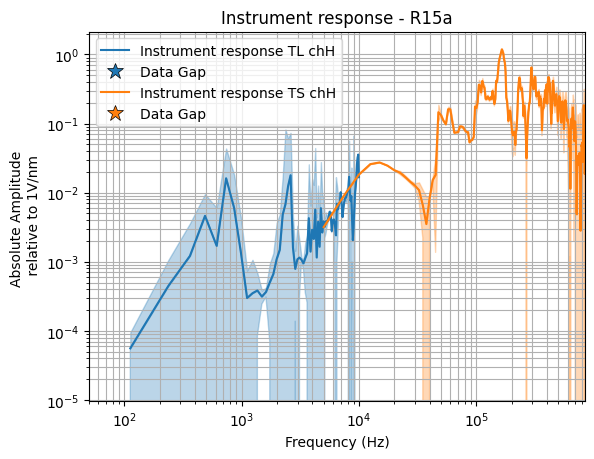

In [16]:
plt.figure(4)
plt.plot(bin_centers_lp, (abs(bin_means_lp/1E9)),
         label='Instrument response TL {:s}'.format(sensor_loc), color='tab:blue')
plt.plot(bin_means_lp_gap,
         (np.min(abs(Iw_TL_stitch_wavg/1E9))*1.2 * np.ones((1, len(bin_means_lp_gap))).flatten()), '*',
         color='tab:blue', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Data Gap')
plt.fill_between(bin_centers_lp,
                 (abs(bin_means_lp/1E9) + abs(bin_std_means_lp/1E9)),
                 (abs(bin_means_lp/1E9)),
                 alpha=0.3, color='tab:blue')
plt.fill_between(bin_centers_lp,
                 (abs(bin_means_lp/1E9) - abs(bin_std_means_lp/1E9)),
                 (abs(bin_means_lp/1E9)),
                 alpha=0.3, color='tab:blue')
plt.plot(Sfreq_TS_stitch, (abs(Iw_TS_stitch_wavg/1E9)),
         label='Instrument response TS {:s}'.format(sensor_loc), color='tab:orange')
plt.plot(Sfreq_TS_stitch_gap, (np.min(abs(Iw_TS_stitch_wavg/1E9))*np.ones((1,len(Sfreq_TS_stitch_gap))).flatten()),'*',
          color='tab:orange', markeredgecolor='black', markeredgewidth=0.5, ms=12, label='Data Gap')
plt.fill_between(Sfreq_TS_stitch,
                 (abs(Iw_TS_stitch_wavg/1E9) + abs(Iw_TS_stitch_std_wavg/1E9)),
                 (abs(Iw_TS_stitch_wavg/1E9)),
                 alpha=0.3, color='tab:orange')
plt.fill_between(Sfreq_TS_stitch,
                 (abs(Iw_TS_stitch_wavg/1E9) - abs(Iw_TS_stitch_std_wavg/1E9)),
                 (abs(Iw_TS_stitch_wavg/1E9)),
                 alpha=0.3, color='tab:orange')
plt.title('Instrument response - {:s}'.format(sensor))
plt.legend()
plt.ylabel('Absolute Amplitude \n relative to 1V/nm')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.xlim(1 / T_L, 1/np.min(tc_all))
plt.show()